# Getting the basic files from Hydrosheds and set them into EF5 format.

### Step 1: Create the basic EF5 Files.

In this code, Ghana 1km files will be created as a example.

Author: Vanessa Robledo (vrobledodelgado@uiowa.edu) 

1. Hydrosheds files at 1km resolution can be downloaded from the following links (click on it), or using wget retriever.

FLOW DIRECTION: https://data.hydrosheds.org/file/hydrosheds-v1-dir/hyd_af_dir_30s.zip

FLOW ACCUMULATION: https://data.hydrosheds.org/file/hydrosheds-v1-acc/hyd_af_acc_30s.zip

DEM: https://data.hydrosheds.org/file/hydrosheds-v1-dem/hyd_af_dem_30s.zip

(If you want to use different resolution, change the path for download the products)

In [1]:
#Use wget and extract the files from the .zip

!wget https://data.hydrosheds.org/file/hydrosheds-v1-dir/hyd_af_dir_30s.zip
!wget https://data.hydrosheds.org/file/hydrosheds-v1-acc/hyd_af_acc_30s.zip
!wget https://data.hydrosheds.org/file/hydrosheds-v1-dem/hyd_af_dem_30s.zip

# Unzip the files
!unzip hyd_af_dir_30s.zip -d hyd_af_dir
!unzip hyd_af_acc_30s.zip -d hyd_af_acc
!unzip hyd_af_dem_30s.zip -d hyd_af_dem

#The corresponding directories will be created int the work directory: hyd_af_dir, hyd_af_acc, and hyd_af_dem
# Clean up the zip files
!rm hyd_af_dir_30s.zip
!rm hyd_af_acc_30s.zip
!rm hyd_af_dem_30s.zip



--2025-06-09 15:36:13--  https://data.hydrosheds.org/file/hydrosheds-v1-dir/hyd_af_dir_30s.zip
Resolving data.hydrosheds.org (data.hydrosheds.org)... 172.67.158.28, 104.21.14.61
Connecting to data.hydrosheds.org (data.hydrosheds.org)|172.67.158.28|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 14601343 (14M) [application/zip]
Saving to: ‘hyd_af_dir_30s.zip’

hyd_af_dir_30s.zip  100%[===================>]  13.92M  19.9MB/s    in 0.7s    

2025-06-09 15:36:15 (19.9 MB/s) - ‘hyd_af_dir_30s.zip’ saved [14601343/14601343]

--2025-06-09 15:36:15--  https://data.hydrosheds.org/file/hydrosheds-v1-acc/hyd_af_acc_30s.zip
Resolving data.hydrosheds.org (data.hydrosheds.org)... 172.67.158.28, 104.21.14.61
Connecting to data.hydrosheds.org (data.hydrosheds.org)|172.67.158.28|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 32036819 (31M) [application/zip]
Saving to: ‘hyd_af_acc_30s.zip’

hyd_af_acc_30s.zip  100%[===================>]  30.55M  24.9MB/s 

Import some libraries (if you need to install any, please use: !pip install library_name).

In [1]:
!pip install rasterio
!pip install geopandas
!pip install rioxarray
!pip install cartopy
!pip install shapely


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray as rxr
import shapely
from shapely.geometry import mapping

Move the .zip file to a unique forder.

Define the path where you place your data.

In [ ]:
main_path = '/Users/vrobledodelgado/GhanaEF5_1km/'  

#If you are using colab use only this line, your path should be something like.
#main_path = '/content/'

Since the HYDROSHEDS files cover entire Africa, it is necessary to clip them to the study region, Ghana. The authors of this workshop have previously prepared the study region file based on the HYDRObasins L3 contributing to Ghana.

In [13]:
##If you are usign Google Colab you will need to upload some files using.
##Please upload all files under GIS_Ghana/L3_basisns_ghana
# from google.colab import files
# uploaded_files = files.upload()

Saving Ghana_SR.prj to Ghana_SR (1).prj
Saving Ghana_SR.dbf to Ghana_SR (1).dbf
Saving Ghana_SR.cpg to Ghana_SR (1).cpg
Saving Ghana_SR.shp to Ghana_SR (2).shp
Saving Ghana_SR.shx to Ghana_SR (1).shx


/Users/vrobledodelgado/anaconda3/envs/vrobledod/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


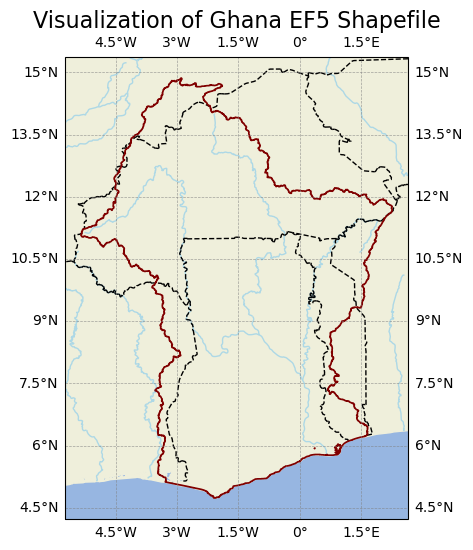

In [6]:
## Load the shapefile for ghana study region
ghana_ef5_shape = gpd.read_file(main_path+'GIS_ghana/L3_basins_ghana/Ghana_SR.shp')

##Colab line
#ghana_ef5_shape = gpd.read_file(main_path+'Ghana_SR.shp')

##Visualization
# Create the figure and axis with geographic projection
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})
# Add country borders, land, ocean and rivers
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS, color='lightblue')
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
# Add the Ghana EF5 shapefile
ghana_ef5_shape.plot(ax=ax, edgecolor='maroon', facecolor='none', linewidth=1.2)
# Style the map
ax.set_title("Visualization of Ghana EF5 Shapefile", fontsize=16)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

plt.show()

Define the paths of you hydrosheds files

In [7]:
path_flowacc = main_path+'GIS_ghana/Hydrosheds/hyd_af_acc/hyd_af_acc_30s.tif'
path_dem = main_path+'GIS_ghana/Hydrosheds/hyd_af_dem/hyd_af_dem_30s.tif'
path_flowdir = main_path+'GIS_ghana/Hydrosheds/hyd_af_dir/hyd_af_dir_30s.tif'

The following function will clip a raster based on a shapefile and set the format for the outputs based on EF5


In [8]:
def clip_raster(pathraster, shapefile):
    raster = rxr.open_rasterio(pathraster,
                           masked=True).squeeze()
    raster_clipped = raster.rio.clip(shapefile.geometry.apply(mapping))
    raster_clipped = raster_clipped.astype('float32')  # Set data type to float32
    array = raster_clipped.values
    array = np.where(np.isnan(array), -9999, array)  #conver nan values to -9999
    raster_output = raster_clipped.copy()
    raster_output.values = array
    raster_output.rio.write_nodata(int(-9999), inplace=True)  # Set NoData value to -9999
    raster_output.rio.write_crs("EPSG:4326", inplace=True)  # Set CRS to EPSG:4326

    return raster_output

Clip the files using the clip_raster function

In [10]:
FACC_clipped = clip_raster(path_flowacc,ghana_ef5_shape)
FACC_clipped.rio.to_raster(main_path+'FAC_ghana1km.tif')

FDIR_clipped = clip_raster(path_flowdir,ghana_ef5_shape)
FDIR_clipped.rio.to_raster(main_path+'FDIR_ghana1km.tif')

DEM_clipped = clip_raster(path_dem,ghana_ef5_shape)
DEM_clipped.rio.to_raster(main_path+'DEM_ghana1km.tif')

#If you are using Colab, please download this files for using them into EF5

Now you are done with your files. Place them into /basic/ folder in your EF5 work directory

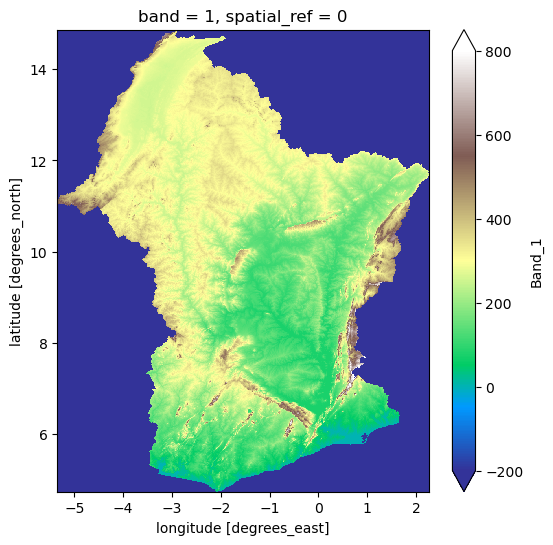

In [11]:
# You can quickly visualize them using:

DEM_clipped.plot(figsize = (6,6),vmin=-200,vmax=800, cmap='terrain')
#FDIR_clipped.plot(figsize = (6,6),vmax = 128, cmap='plasma')
#FACC_clipped.plot(figsize = (6,6),cmap='Blues',vmax=250)